In [15]:
%load_ext autoreload
%autoreload 2
%pylab inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import tensorflow as tf
import numpy as np
import os
import sys
import glob
import pandas as pd

from collections import Counter
from numpy import array as _A

import common_utils

config = common_utils.get_config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [16]:
all_txt_files = glob.glob(config.data_dir+'/*/*/*.txt')
print("Total number of files %d"%len(all_txt_files))
labels = list({a.split('/')[-3] for a in all_txt_files})
print("Labels",labels)

Total number of files 19331
Labels ['liberal', 'conservative']


In [17]:
ignore_words=open(config['ignore_words_path'],'rt').readlines()
ignore_words = {a.strip() for a in ignore_words}
print("Read %d ignore words"%len(ignore_words))

trival_words = open(config['trival_words_path'], 'rt').readlines()
trival_words = {a.strip() for a in trival_words}
print ("Read %d trival words such as:"%(len(trival_words)), trival_words)

Read 2 ignore words
Read 23 trival words such as: {'for', 'you', 'it', 'have', 'to', 'this', 'at', 'the', 'that', '-', 'he', 'has', 'with', 'was', 'i', 'in', 'an', 'and', 'is', 'a', 'as', 'on', 'of'}


In [18]:
def process_single_file(full_path):
    #txt = list()
    lines = open(full_path, 'rt').readlines()
    num_skipped = 0 
    header = lines.pop(0).lower() # Extract header
    word_counter = Counter()
    label = full_path.split('/')[-3]
    
    for line in lines:
        line = line.strip().lower() #Remove white spaces, lower case all
        skip = False
        for ignore_word in ignore_words:
            if ignore_word in line:
                skip = True
                break
        if skip:
            num_skipped +=1 
        else:
            #txt.append(line)
            for word in line.split():
                word = word.strip()
                if word not in trival_words:
                    word_counter.update([word])
    return word_counter, label, full_path

full_path=all_txt_files[0]
word_counter, label, full_path = process_single_file(full_path)
#concated_txt = '\n '.join(txt)
#print('valid %d, skipped %d, concatnated %d, total sum words %d'%(len(txt), num_skipped, len(concated_txt), total_num_words))
total_num_words = sum([a for a in word_counter.values()])
print('total %d number of words, total sum words %d'%(len(word_counter), total_num_words))


total 1162 number of words, total sum words 2618


In [19]:
#Proces all files
per_label={label:Counter() for label in labels}
for i, full_path in enumerate(all_txt_files):
    word_counter, label, full_path = process_single_file(full_path)
    per_label[label].update(word_counter)
    if i%1000==0 and i>0:
        print("processed %d"%i)
        
    #if i>12000:break
        

processed 1000
processed 2000
processed 3000
processed 4000
processed 5000
processed 6000
processed 7000
processed 8000
processed 9000
processed 10000
processed 11000
processed 12000
processed 13000
processed 14000
processed 15000
processed 16000
processed 17000
processed 18000
processed 19000


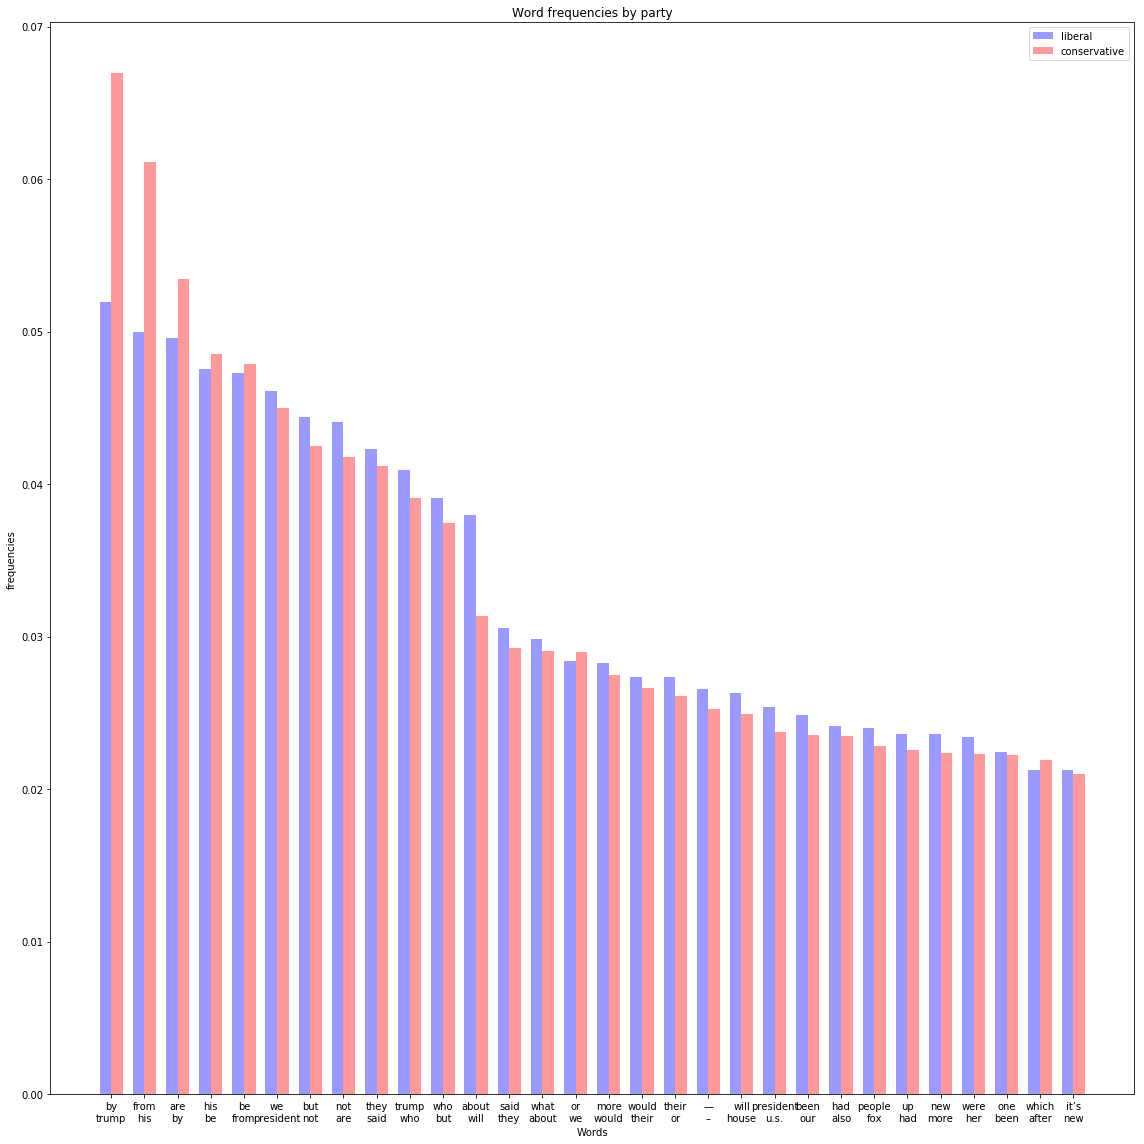

In [20]:
plt.rcParams["figure.figsize"] = 16,16

most_common = dict()
for label in labels:
    words, words_counts = zip(*per_label[label].most_common()[:30])
    words_counts = _A(words_counts, np.float32)/np.sum(words_counts)
    most_common[label]={"words":_A(words), "counts":words_counts}


indexes = np.arange(len(most_common[labels[0]]['words']))    
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.4
error_config = {'ecolor': '0.3'}

a = most_common[labels[0]]
b = most_common[labels[1]]

rects1 = plt.bar(indexes, a['counts'], bar_width,
                 alpha=opacity,
                 color='b',
                 label=labels[0])

rects2 = plt.bar(indexes + bar_width, b['counts'], bar_width,
                 alpha=opacity,
                 color='r',
                 label=labels[1])

plt.xlabel('Words')
plt.ylabel('frequencies')
plt.title('Word frequencies by party')
concated_words = [a+'\n'+b for a,b in zip(a['words'], b['words'])]
plt.xticks(indexes + bar_width / 2, concated_words)

if 0:
    for tick in gca().xaxis.iter_ticks():
        tick[0].label1.set_rotation('vertical')
    
plt.legend()

plt.tight_layout()
show()

In [21]:
df_consr = pd.DataFrame.from_dict(most_common[labels[0]], orient='index').reset_index()
df_libel = pd.DataFrame.from_dict(most_common[labels[1]], orient='index').reset_index()

df_consr

,index,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,words,by,from,are,his,be,we,but,not,they,...,president,been,had,people,up,new,were,one,which,it’s
1,counts,0.0519732,0.0500011,0.0496144,0.0475533,0.0472601,0.0460818,0.0444268,0.044104,0.0422744,...,0.0253724,0.0248488,0.0241131,0.0240013,0.0236466,0.0236147,0.0234185,0.0224227,0.0212775,0.0212741


In [22]:
df_libel

,index,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,words,trump,his,by,be,from,president,not,are,said,...,u.s.,our,also,fox,had,more,her,been,after,new
1,counts,0.0669293,0.0611379,0.0534351,0.0485582,0.0478923,0.0449777,0.0424982,0.0417656,0.0411618,...,0.0237186,0.0235388,0.0234589,0.0227996,0.0225599,0.0223978,0.0223246,0.0222114,0.0219383,0.0210171
